In [1]:
!pip install torch torchvision

#CIFAR_10のデータのDL

import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
from torch.cuda.amp import GradScaler, autocast
from torchvision import datasets, transforms, models
from torchvision.models import efficientnet_v2_s, EfficientNet_V2_S_Weights



transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.Resize(400),
    transforms.CenterCrop(384),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])


transform_test = transforms.Compose([
    transforms.Resize(400),
    transforms.CenterCrop(384),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])



train_dataset = torchvision.datasets. CIFAR10(
    './cifar-10', train=True, download=True,
    transform=transform_train)


test_data = torchvision.datasets. CIFAR10(
    './cifar-10', train=False, download=True,
    transform=transform_test)

# train_dataをshuffleしてから分割

train_data, val_data = torch.utils.data.random_split(train_dataset, [40000, 10000])

train_loader = torch.utils.data.DataLoader(train_data,  batch_size=64, shuffle = True, num_workers = 2)
val_loader = torch.utils.data.DataLoader(val_data, batch_size = 64)

100%|██████████| 170498071/170498071 [00:02<00:00, 70576532.77it/s]


Extracting ./cifar-10/cifar-10-python.tar.gz to ./cifar-10
Files already downloaded and verified


In [2]:
import numpy as np
import matplotlib.pyplot as plt



weights =  EfficientNet_V2_S_Weights.DEFAULT

effmodel = models.efficientnet_v2_s(weights = weights)

#最後の全結合層を取っ払う
effmodel.classifier = torch.nn.Identity()

#最後のチャネル数を調査

# dummy_input = torch.randn(1, 3, 224, 224)
# features = effmodel(dummy_input)
# num_channels = features.size(1)
# print(num_channels)

Downloading: "https://download.pytorch.org/models/efficientnet_v2_s-dd5fe13b.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_v2_s-dd5fe13b.pth
100%|██████████| 82.7M/82.7M [00:00<00:00, 214MB/s]


In [3]:

#シードの固定

torch.manual_seed(4931)

# インプットするデータは、32H×32W×3C(R,G,B)という次元なので、それに合うような入力はそれに合わせる。
# 最終結果は10クラスなので出力はこれに合わせる。

class EffNetFT(nn.Module):
    def __init__(self, dropout_rate = 0.55):
        super(EffNetFT, self).__init__()
        self.conv = effmodel
        self.fc = nn.Linear(1280,10)
        self.dropout = nn.Dropout(dropout_rate)
        
    def forward(self, x):
        x = self.conv(x)
        x = torch.flatten(x, 1)  
        x = self.dropout(x)
        x = self.fc(x)
        return x

# Instantiate the network
net = EffNetFT()

# Freeze the pre-trained layers
for param in net.conv.parameters():
    param.requires_grad = False

# Only train the fully connected layer
for param in net.fc.parameters():
    param.requires_grad = True
    


    
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
net = net.to(device)


# データ並列学習 ON
net = nn.DataParallel(net)




In [4]:
# 交差エントロピー
criterion = nn.CrossEntropyLoss()
# 確率的勾配降下法
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

Epoch 1/100
Training loss: 1.959, Training accuracy: 37.020%
Validation loss: nan, Validation accuracy: 53.380%
Epoch 2/100
Training loss: 1.621, Training accuracy: 48.612%
Validation loss: 1.418, Validation accuracy: 57.810%
Epoch 3/100
Training loss: 0.583, Training accuracy: 80.353%
Validation loss: 0.388, Validation accuracy: 86.640%
Epoch 4/100
Training loss: 0.368, Training accuracy: 87.460%
Validation loss: 0.292, Validation accuracy: 89.960%
Epoch 5/100
Training loss: 0.306, Training accuracy: 89.713%
Validation loss: 0.307, Validation accuracy: 89.810%
Epoch 6/100
Training loss: 0.262, Training accuracy: 90.938%
Validation loss: 0.274, Validation accuracy: 90.550%
Epoch 7/100
Training loss: 0.234, Training accuracy: 92.075%
Validation loss: 0.240, Validation accuracy: 91.980%
Epoch 8/100
Training loss: 0.214, Training accuracy: 92.635%
Validation loss: 0.224, Validation accuracy: 92.680%
Epoch 9/100
Training loss: 0.196, Training accuracy: 93.245%
Validation loss: 0.233, Valid

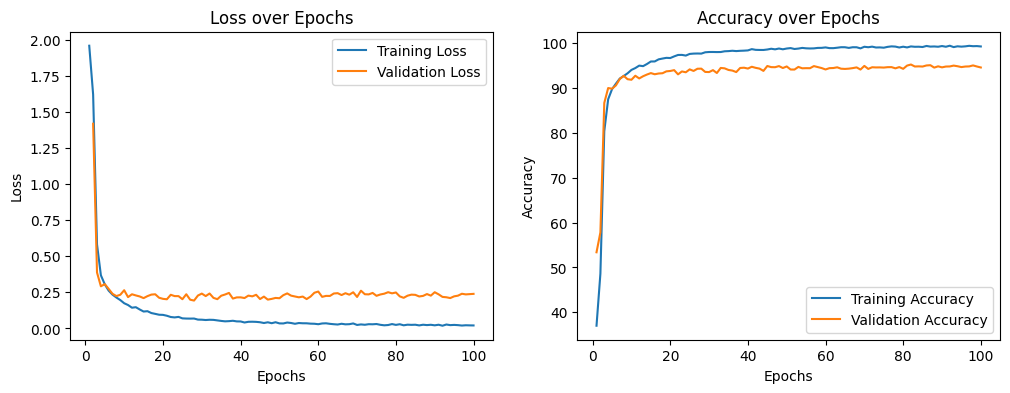

In [5]:


# Initialize the gradient scaler
scaler = GradScaler()

num_epochs = 100
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(num_epochs):
    # Training
    net.train()  # Set the model to training mode
    running_loss = 0.0
    correct_train = 0
    total_train = 0
    
    if epoch == 2:
        for param in net.module.conv.parameters():
            param.requires_grad = True
            
        optimizer = optim.Adam([
            {'params': net.module.conv.parameters()},
            {'params': net.module.fc.parameters()}
        ], lr=0.001)
            
            
        

    for data in train_loader:                                     #enumerateでバッチに番号を振り、iでそれを引っ張ってくる。dataは一個ずつ引っ張り出してくるのではなく一気にバッチで学習する。
        inputs, labels = data                                     #画像データ,正解ラベルのペアになっているのを分解
        inputs, labels = inputs.to(device), labels.to(device)     #GPUに載せる
        optimizer.zero_grad()                                     #勾配を0に設定
        
        # Runs the forward pass with mixed precision
        with autocast():
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            
       
        scaler.scale(loss).backward()                             # Scales loss. Calls backward() on scaled loss to create scaled gradients.
        scaler.step(optimizer)                                    # Scaler step. Unscales gradients and calls or skips optimizer.step()
        scaler.update()
        optimizer.zero_grad() 

        running_loss += loss.item()                               #各データの損失を、テンソルから普通の数字(フロート)に変換し、epochごとの損失を得るために足し合わせる。
        _, predicted = torch.max(outputs.data, 1)                 # 1:データの各クラス間 の最大値を、確率とその値を返す。
        total_train += labels.size(0)                             # バッチに含まれているデータの数を継ぎ足す。
        correct_train += (predicted == labels).sum().item()       # 正解した分のみを正答数に継ぎ足す。

    train_losses.append(running_loss / len(train_loader))         # epochごとに、平均損失リストに加えていく。
    train_accuracies.append(100 * correct_train / total_train)    # epochごとに正答率リストに加えていく。

    # Validation
    net.eval()  # Set the model to evaluation mode
    val_loss = 0.0
    correct_val = 0
    total_val = 0
    with torch.no_grad(), autocast():
        for data in val_loader:
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    val_losses.append(val_loss / len(val_loader))
    val_accuracies.append(100 * correct_val / total_val)

    print(f'Epoch {epoch+1}/{num_epochs}')
    print(f'Training loss: {train_losses[-1]:.3f}, Training accuracy: {train_accuracies[-1]:.3f}%')
    print(f'Validation loss: {val_losses[-1]:.3f}, Validation accuracy: {val_accuracies[-1]:.3f}%')

print('Finished Training')

# Plot the training and validation loss
plt.figure(figsize=(12, 4))                                              # 横12インチ、縦4インチのグラフを作成
plt.subplot(1, 2, 1)                                                     # 1行 2列にグラフを表示、最初に左からグラフをプロットする。
plt.plot(range(1, num_epochs+1), train_losses, label='Training Loss')
plt.plot(range(1, num_epochs+1), val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss over Epochs')
plt.legend()

# Plot the training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs+1), train_accuracies, label='Training Accuracy')
plt.plot(range(1, num_epochs+1), val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy over Epochs')
plt.legend()

plt.show()



In [6]:
from sklearn import metrics
test_loader = torch.utils.data.DataLoader(test_data)

label_list = []
pred_list = []

with torch.no_grad():
    for data, label in test_loader:
        data = data.to('cuda')
        output = net(data)
        _, pred = torch.max(output, 1)

        label_list.extend(label.cpu().numpy().tolist())
        pred_list.extend(pred.cpu().numpy().tolist())


print(metrics.classification_report(pred_list,label_list))

score = metrics.accuracy_score(label_list,pred_list)
print(score)

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


              precision    recall  f1-score   support

           0       0.94      0.98      0.96       958
           1       0.98      0.96      0.97      1028
           2       0.93      0.96      0.95       967
           3       0.87      0.95      0.91       915
           4       0.97      0.96      0.97      1006
           5       0.94      0.91      0.93      1031
           6       0.98      0.96      0.97      1027
           7       0.99      0.95      0.97      1044
           8       0.98      0.94      0.96      1051
           9       0.94      0.97      0.96       973

    accuracy                           0.95     10000
   macro avg       0.95      0.95      0.95     10000
weighted avg       0.95      0.95      0.95     10000

0.9535
